# Fit for the select lines

In [1]:
# imports
from importlib import reload
import numpy as np

from pypeit.core.wavecal import wvutils
from pypeit.core.wavecal import fitting
from pypeit import utils

import lrisb_tinkering as lbt
reload(lbt)

<module 'lrisb_tinkering' from '/home/xavier/local/Python/PypeIt-development-suite/dev_algorithms/wavelengths/lrisb_tinkering.py'>

## Load up

In [2]:
slit = 13

In [3]:
tspec, mspec, mwv, targ_wv, targ_y = lbt.target_lines(slit)

In [4]:
ntarg = targ_wv.size
ntarg

14

## Find new lines

In [5]:
all_tcent, all_ecent, cut_tcent, icut, arc_cont_sub = wvutils.arc_lines_from_spec(tspec)

In [6]:
all_tcent

array([  38.10355334,   91.89876359,  127.39915479,  213.31936038,
        234.7661268 ,  245.91597639,  256.60627901,  568.46783043,
        593.5139902 ,  691.00418075,  754.21916488,  785.89354833,
        816.56208105, 1030.5417483 , 1069.71404062, 1103.3182084 ,
       1164.52282462, 1172.8405715 , 1389.68031371, 1686.96968393,
       1774.51462898, 1906.63752008, 1934.92908096, 1943.37032512,
       1951.98525721, 2026.1252217 ])

## Grab initial guess

In [7]:
n_order = 3
func = 'legendre'
sigrej_first = 3.
fmin, fmax = 0., 1.
xfit = np.arange(mwv.size)
yfit = mwv
initial_mask = mwv <= 0.
i1 = np.where(~initial_mask)[0][0]
disp = mwv[i1+1]-mwv[i1]
disp

1.1529066715511362

In [8]:
yfit[~initial_mask]

array([3369.87025799, 3371.02316466, 3372.17630738, ..., 5920.30894672,
       5921.5595237 , 5922.81001483])

In [9]:
mask, fit = utils.robust_polyfit(xfit, yfit, n_order, function=func, sigma=sigrej_first,
                                 initialmask=initial_mask,
                                         minx=fmin, maxx=fmax, verbose=True)#, weights=wfit)

In [10]:
xfit[~initial_mask]

array([   0,    1,    2, ..., 2045, 2046, 2047])

In [11]:
rms_ang = utils.calc_fit_rms(xfit[mask == 0], yfit[mask == 0], fit, func, minx=fmin, maxx=fmax)
#                                     weights=wfit[mask == 0])
rms_pix = rms_ang/disp
rms_pix

0.9974767642110087

In [12]:
fit

array([ 3.37186929e+03,  5.74831250e-01,  1.48538069e-05, -1.01251660e-09])

## Apply to new lines

In [13]:
new_wv = utils.func_val(fit, all_tcent, func, minx=fmin, maxx=fmax)
nnew = new_wv.size

## Generate difference grid

In [14]:
targ_grid = np.outer(targ_wv, np.ones(nnew))
new_grid = np.outer(np.ones(ntarg), new_wv)

In [15]:
diff = np.abs(targ_grid - new_grid)

In [16]:
mgrid = np.min(diff, axis=1)
mgrid

array([ 8.68477998,  5.28751478,  5.20491925,  1.593254  ,  1.74688588,
        0.81917933,  1.50415131,  2.35988342,  2.66606005,  2.3288189 ,
        1.23140817,  4.24846928, 11.81401315,  1.09820317])

### Could toss the 2 worst here (or sig clip)

In [17]:
loss = mgrid**2 * targ_y

----

## Try it

In [18]:
fit

array([ 3.37186929e+03,  5.74831250e-01,  1.48538069e-05, -1.01251660e-09])

In [19]:
bounds = [ [fit[0]-50., fit[0]+50],
         [fit[1]*0.8, fit[1]*1.2],
         [fit[2]*-2, fit[2]*2],
          [fit[3]*-2, fit[3]*2]]

In [20]:
bounds

[[3321.8692940479305, 3421.8692940479305],
 [0.45986500030998284, 0.6897975004649742],
 [-2.970761375108348e-05, 2.970761375108348e-05],
 [2.0250332054237358e-09, -2.0250332054237358e-09]]

In [21]:
reload(lbt)
result = lbt.fitme(bounds, all_tcent, targ_grid, targ_y)

differential_evolution step 1: f(x)= 7.53933e+07
differential_evolution step 2: f(x)= 3.57149e+07
differential_evolution step 3: f(x)= 1.98295e+07
differential_evolution step 4: f(x)= 1.98295e+07
differential_evolution step 5: f(x)= 1.39423e+07
differential_evolution step 6: f(x)= 1.39423e+07
differential_evolution step 7: f(x)= 1.39423e+07
differential_evolution step 8: f(x)= 1.39423e+07
differential_evolution step 9: f(x)= 4.50678e+06
differential_evolution step 10: f(x)= 1.62342e+06
differential_evolution step 11: f(x)= 1.62342e+06
differential_evolution step 12: f(x)= 1.62342e+06
differential_evolution step 13: f(x)= 1.37596e+06
differential_evolution step 14: f(x)= 1.37596e+06
differential_evolution step 15: f(x)= 1.37596e+06
differential_evolution step 16: f(x)= 1.37596e+06
differential_evolution step 17: f(x)= 1.37596e+06
differential_evolution step 18: f(x)= 985010
differential_evolution step 19: f(x)= 985010
differential_evolution step 20: f(x)= 352685
differential_evolution s

In [22]:
result

     fun: array(0.)
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 6000
     nit: 99
 success: True
       x: array([ 3.35915147e+03,  5.85140273e-01,  1.47307650e-05, -1.26372317e-09])

In [23]:
final_wv = utils.func_val(result.x, all_tcent, func, minx=fmin, maxx=fmax)
final_wv

array([3403.28180314, 3466.83270083, 3509.03071785, 3611.96932041,
       3637.83420892, 3651.30673525, 3664.2402782 , 4047.7141572 ,
       4078.95521668, 4201.05539233, 4280.60289305, 4320.55709201,
       4359.29768372, 4630.74265097, 4680.5806445 , 4723.35267228,
       4801.2786821 , 4811.8697221 , 5087.69111673, 5462.94373181,
       5572.29526921, 5735.95722749, 5770.7593713 , 5781.12523447,
       5791.69572699, 5882.28947933])

In [24]:
targ_wv

array([3611.69631063, 3651.11454808, 3664.28820811, 4048.28700969,
       4079.00672906, 4359.23115343, 4679.74272335, 4723.32893932,
       4801.58700243, 4811.8547367 , 5087.89190634, 5462.83996364,
       5770.90958433, 5792.31955426])

## ID lines

In [25]:
# Match to line list
IDs = []
dwv = mwv[i1+1] - mwv[i1]
lmask = np.zeros(final_wv.size, dtype=bool)
for kk, iwv in enumerate(final_wv):
    imin = np.argmin(np.abs(iwv - lbt.llist['wave']))
    if np.abs(iwv - lbt.llist['wave'][imin]) < dwv:
        lmask[kk] = True
        IDs.append(lbt.llist['wave'][imin])

In [26]:
lmask, IDs

(array([False,  True, False,  True, False,  True,  True,  True,  True,
        False, False, False,  True, False,  True,  True,  True,  True,
         True,  True, False, False,  True, False,  True, False]),
 [3467.1923,
  3611.5375,
  3651.198,
  3664.327,
  4047.708,
  4078.988,
  4359.56,
  4681.45,
  4723.47,
  4801.254,
  4811.87,
  5087.2393,
  5462.268,
  5771.21,
  5792.276])

## Fit

In [27]:
fitting.iterative_fitting(tspec, all_tcent, np.where(lmask)[0], np.array(IDs), lbt.llist, dwv, 
                          verbose=True, plot_fil='tmp.png', n_first=3)

[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 3: RMS = 0.245852
[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 4: RMS = 0.0364312
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 3467.19; 3467.6
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 3611.54; 3611.97
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 3664.33; 3664.11
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 4681.45; 4680.74
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 5574.09; 5571.86


{'cen_disp': 1.2706258445850835,
 'cen_wave': 4622.6438428727115,
 'fitc': array([ 4.62557143e+03,  1.28512543e+03,  8.02279161e+00, -1.05318886e+01,
         1.19599600e+00, -2.33441507e-01]),
 'fmax': 1.0,
 'fmin': 0.0,
 'function': 'legendre',
 'ions': array(['CdI', 'CdI', 'CdI', 'HgI', 'HgI', 'HgI', 'HgI', 'HgI', 'ZnI',
        'ZnI', 'CdI', 'ZnI', 'CdI', 'HgI', 'ArI', 'HgI', 'HgI', 'NeI'],
       dtype='<U6'),
 'mask': array([ True, False, False,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True]),
 'nrej': 3.0,
 'nspec': 2048,
 'pixel_fit': array([  38.10355334,   91.89876359,  213.31936038,  245.91597639,
         256.60627901,  568.46783043,  593.5139902 ,  816.56208105,
        1069.71404062, 1103.3182084 , 1164.52282462, 1172.8405715 ,
        1389.68031371, 1686.96968393, 1774.51462898, 1934.92908096,
        1951.98525721, 2026.1252217 ]),
 'rms': 0.016132471986529368,
 'shift': 0.0,
 'spec': array([40.68923531, 

----

# One go

In [31]:
reload(lbt)
final_fit = lbt.do_it_all(11, '600', plot_fil='tst.png')

differential_evolution step 1: f(x)= 2.69686e+07
differential_evolution step 2: f(x)= 2.69686e+07
differential_evolution step 3: f(x)= 2.28445e+07
differential_evolution step 4: f(x)= 6.90001e+06
differential_evolution step 5: f(x)= 2.76754e+06
differential_evolution step 6: f(x)= 2.76754e+06
differential_evolution step 7: f(x)= 2.76754e+06
differential_evolution step 8: f(x)= 2.76754e+06
differential_evolution step 9: f(x)= 2.76754e+06
differential_evolution step 10: f(x)= 2.76754e+06
differential_evolution step 11: f(x)= 2.76754e+06
differential_evolution step 12: f(x)= 2.76754e+06
differential_evolution step 13: f(x)= 2.76754e+06
differential_evolution step 14: f(x)= 2.76754e+06
differential_evolution step 15: f(x)= 2.76754e+06
differential_evolution step 16: f(x)= 2.76754e+06
differential_evolution step 17: f(x)= 2.76754e+06
differential_evolution step 18: f(x)= 1.52213e+06
differential_evolution step 19: f(x)= 1.52213e+06
differential_evolution step 20: f(x)= 1.52213e+06
different

[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 2: RMS = 3.76899
[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 3: RMS = 0.279655
[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 4: RMS = 0.0686988


## Reidentify

Shift = 497.15103481075994; cc = 0.610719334919039


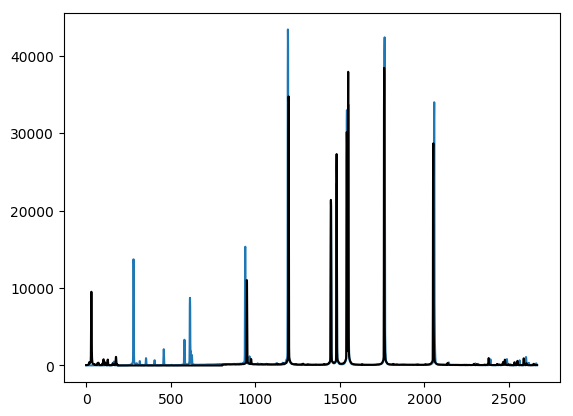

Target lines: [4048.28700969 4079.00672906 4359.23115343 4679.74272335 4723.32893932
 4801.58700243 4811.8547367  5087.89190634 5462.83996364 5770.90958433
 5792.31955426 5853.90846946 5882.75227647 5930.3111524  5946.5528839
 5976.49830665 6031.26115194 6075.92935017 6098.21508359 6145.15295237
 6164.87043195 6218.9481473 ]


[INFO]    :: autoid.py 481 reidentify() - Cross-correlating with arxiv slit # 0


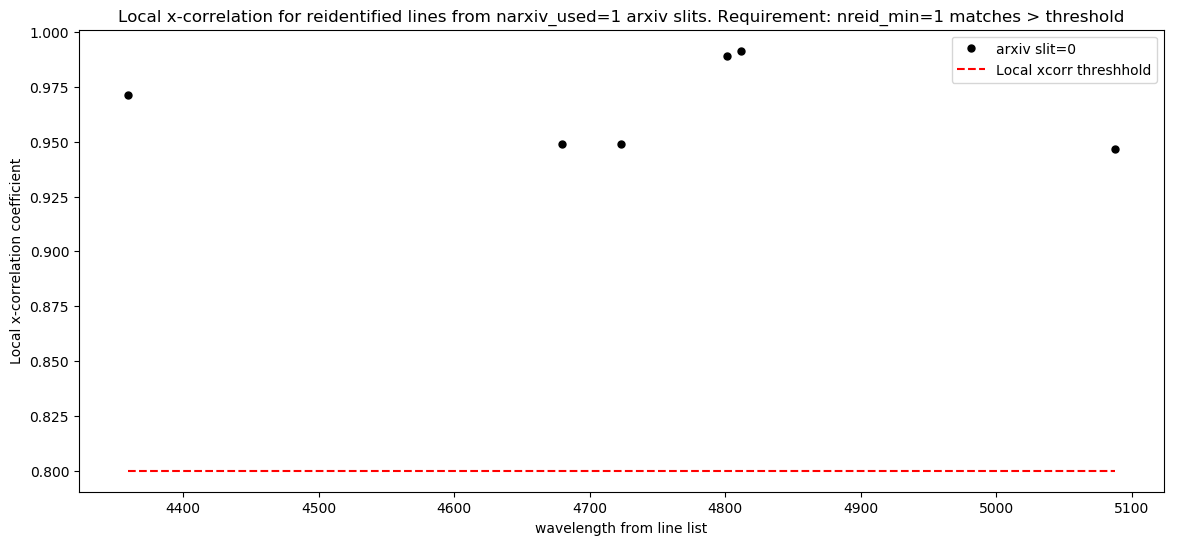

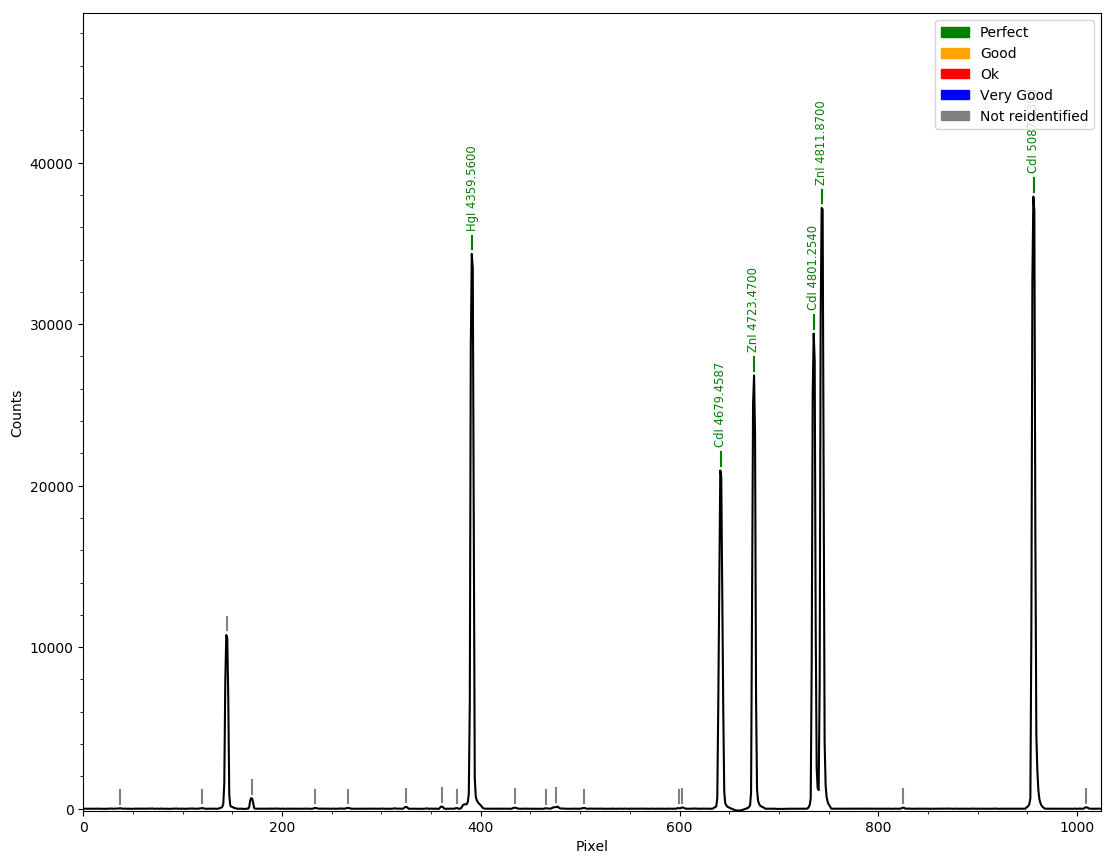

[INFO]    :: autoid.py 481 reidentify() - Cross-correlating with arxiv slit # 0


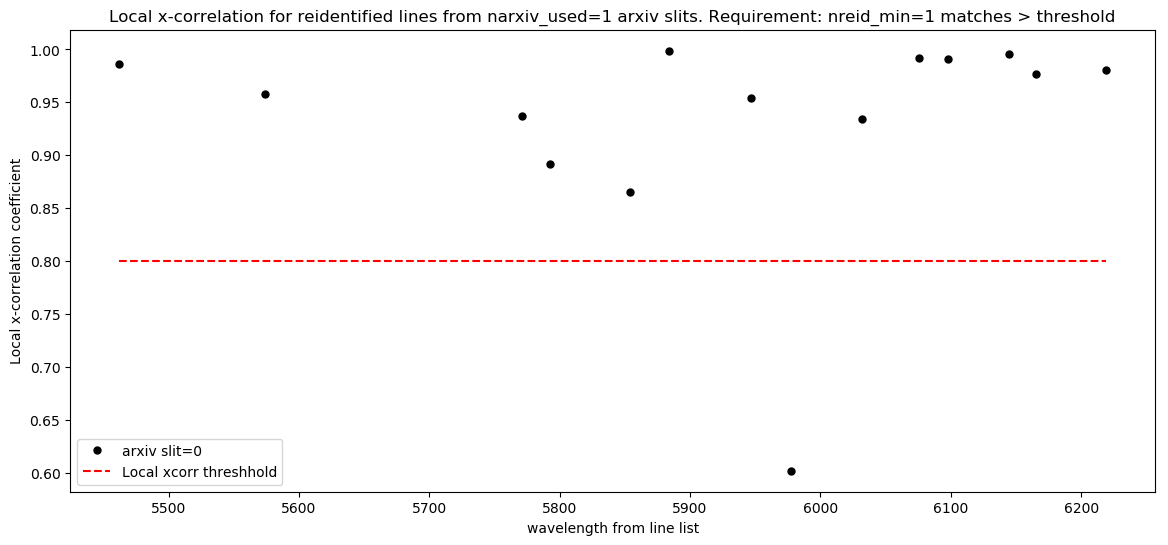

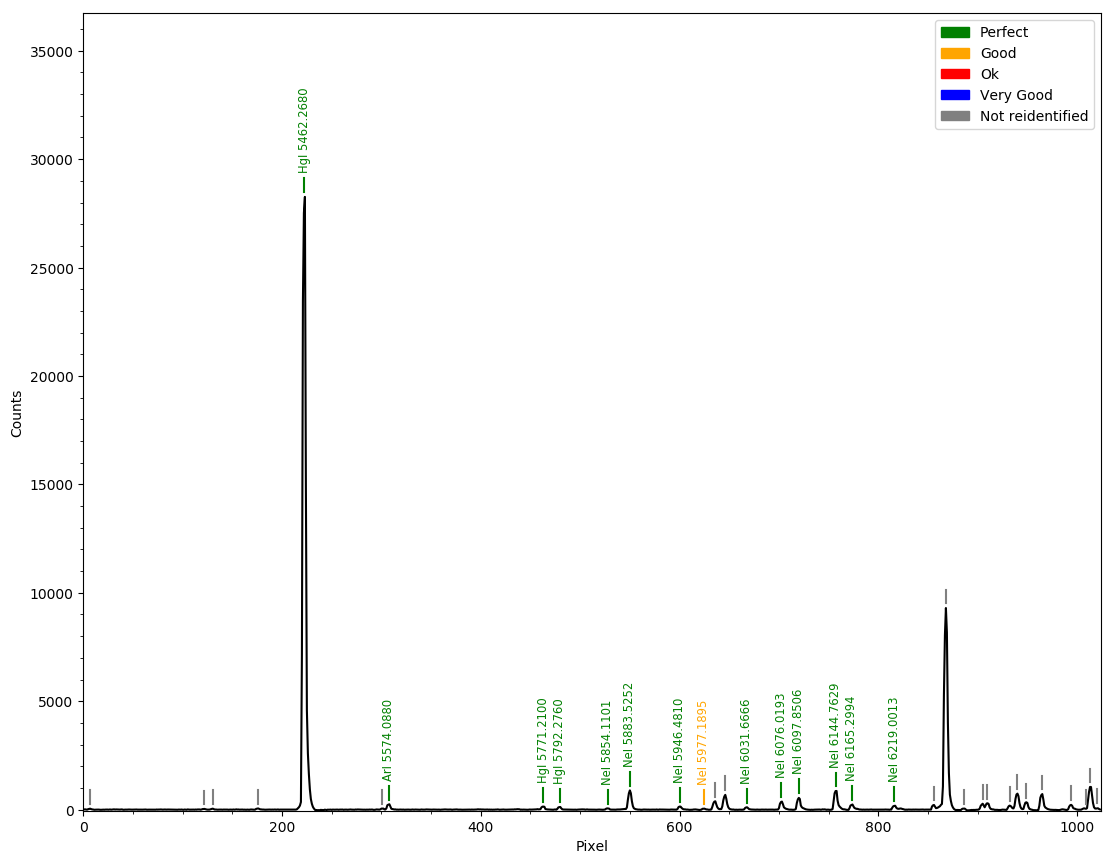

[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 2: RMS = 0.0969419
[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 3: RMS = 0.130296
[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 4: RMS = 0.00824139
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 4681.45; 4680.47
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 5574.09; 5571.79
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 5771.21; 5771.06
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 5854.11; 5853.93
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 5883.53; 5882.46
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 6268.23; 6268.56
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 6306.53; 6306.1
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 6336.18; 6335.88


In [39]:
reload(lbt)
final_fit = lbt.reid_in_steps(9, '600', plot_fil='600.png')